# Análise da Direção do Vento

Este notebook apresenta uma análise detalhada da direção do vento em diferentes alturas, explorando padrões de variação, distribuição e relação com a velocidade do vento.

In [27]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
from scipy import stats
import sys
import os
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker

# Importar bibliotecas para rosa dos ventos
try:
    from windrose import WindroseAxes
except ImportError:
    !pip install windrose
    from windrose import WindroseAxes

# Adicionar diretório src ao path para importar o módulo utils
sys.path.append('../src')
import utils

# Configurar estilo de visualização
colors = utils.set_plotting_style()

# Configurar opções de visualização do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## 1. Carregamento dos Dados

Primeiro, carregamos os dados do perfil de vento para nossa análise.

In [28]:
# Carregar dados
data_path = '../data/dataset.csv'
df = utils.load_wind_data(data_path)

# Obter colunas de direção do vento
wdir_cols = utils.get_height_columns(df, 'wdir')
heights_wdir = [int(col.replace('wdir', '')) for col in wdir_cols]

# Obter colunas de velocidade do vento (úteis para análises conjuntas)
ws_cols = utils.get_height_columns(df, 'ws')
heights_ws = [int(col.replace('ws', '')) for col in ws_cols]

print(f"Período de tempo coberto: {df.index.min()} até {df.index.max()}")
print(f"Número de medições: {len(df)}")
print(f"Alturas disponíveis para direção do vento: {sorted(heights_wdir)}")

Período de tempo coberto: 2021-09-16 18:00:00 até 2021-11-08 14:29:59
Número de medições: 7561
Alturas disponíveis para direção do vento: [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 220, 240, 260]


## 2. Estatísticas Básicas da Direção do Vento

Vamos analisar estatísticas básicas da direção do vento. É importante notar que a direção do vento é uma variável circular, o que requer técnicas especiais de análise.

In [29]:
# Função para calcular estatísticas circulares
def circular_stats(degrees):
    """Calcula estatísticas circulares para ângulos em graus."""
    # Converter de graus para radianos
    radians = np.radians(degrees)
    
    # Calcular média circular
    sin_mean = np.mean(np.sin(radians))
    cos_mean = np.mean(np.cos(radians))
    mean_direction_rad = np.arctan2(sin_mean, cos_mean)
    mean_direction_deg = (np.degrees(mean_direction_rad) + 360) % 360
    
    # Calcular comprimento médio resultante (medida de dispersão)
    r = np.sqrt(sin_mean**2 + cos_mean**2)
    
    # Desvio padrão circular (em graus)
    circular_std = np.sqrt(-2 * np.log(r)) * 180 / np.pi
    
    return {
        'mean_direction': mean_direction_deg,
        'resultant_length': r,
        'circular_std': circular_std
    }

In [30]:
# Calcular estatísticas circulares para cada altura
circular_statistics = []

for col in wdir_cols:
    height = int(col.replace('wdir', ''))
    stats = circular_stats(df[col].dropna())
    stats['height'] = height
    circular_statistics.append(stats)

# Criar DataFrame com estatísticas
circular_df = pd.DataFrame(circular_statistics).sort_values('height')
circular_df

,mean_direction,resultant_length,circular_std,height
0,57.788427,0.957394,16.907739,40
1,57.795198,0.958487,16.684701,50
2,57.782828,0.959302,16.516629,60
3,57.779422,0.960009,16.369385,70
4,57.791386,0.960617,16.241979,80
5,57.804588,0.961065,16.147592,90
6,57.821716,0.961431,16.069815,100
7,57.840844,0.961790,15.993424,110
8,57.864191,0.962116,15.923747,120
9,57.897531,0.962431,15.856134,130


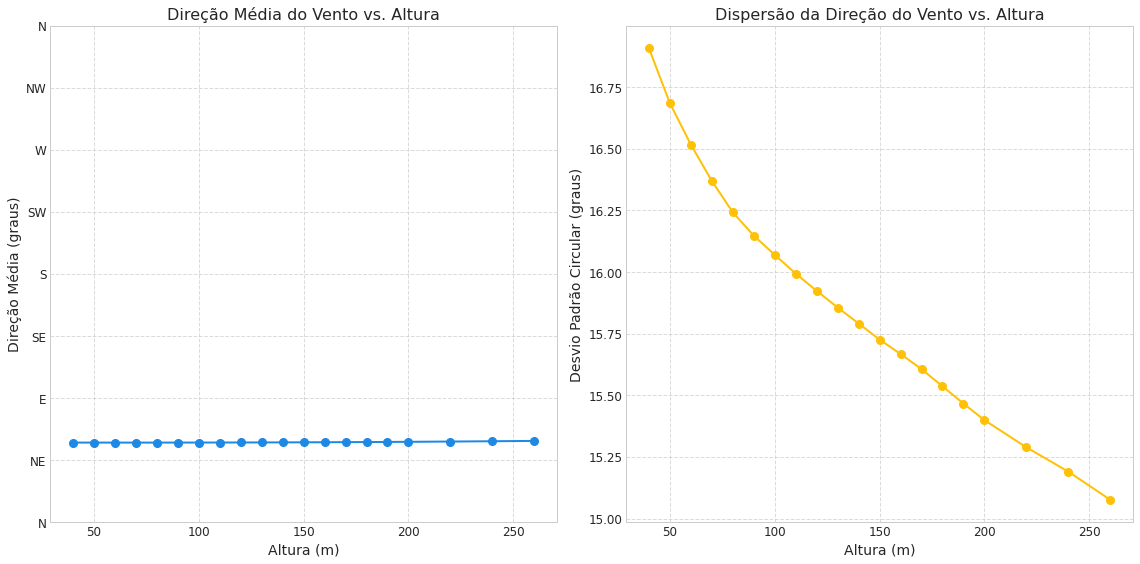

In [31]:
# Visualizar como a direção média e dispersão variam com a altura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plotar direção média
ax1.plot(circular_df['height'], circular_df['mean_direction'], marker='o', 
         linewidth=2, markersize=8, color=colors[0])
ax1.set_title('Direção Média do Vento vs. Altura', fontsize=16)
ax1.set_xlabel('Altura (m)', fontsize=14)
ax1.set_ylabel('Direção Média (graus)', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_ylim(0, 360)
ax1.set_yticks(np.arange(0, 361, 45))
ax1.set_yticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'])

# Plotar dispersão circular
ax2.plot(circular_df['height'], circular_df['circular_std'], marker='o', 
         linewidth=2, markersize=8, color=colors[1])
ax2.set_title('Dispersão da Direção do Vento vs. Altura', fontsize=16)
ax2.set_xlabel('Altura (m)', fontsize=14)
ax2.set_ylabel('Desvio Padrão Circular (graus)', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 3. Distribuição da Direção do Vento

A distribuição da direção do vento é melhor visualizada usando gráficos polares ou rosas dos ventos.

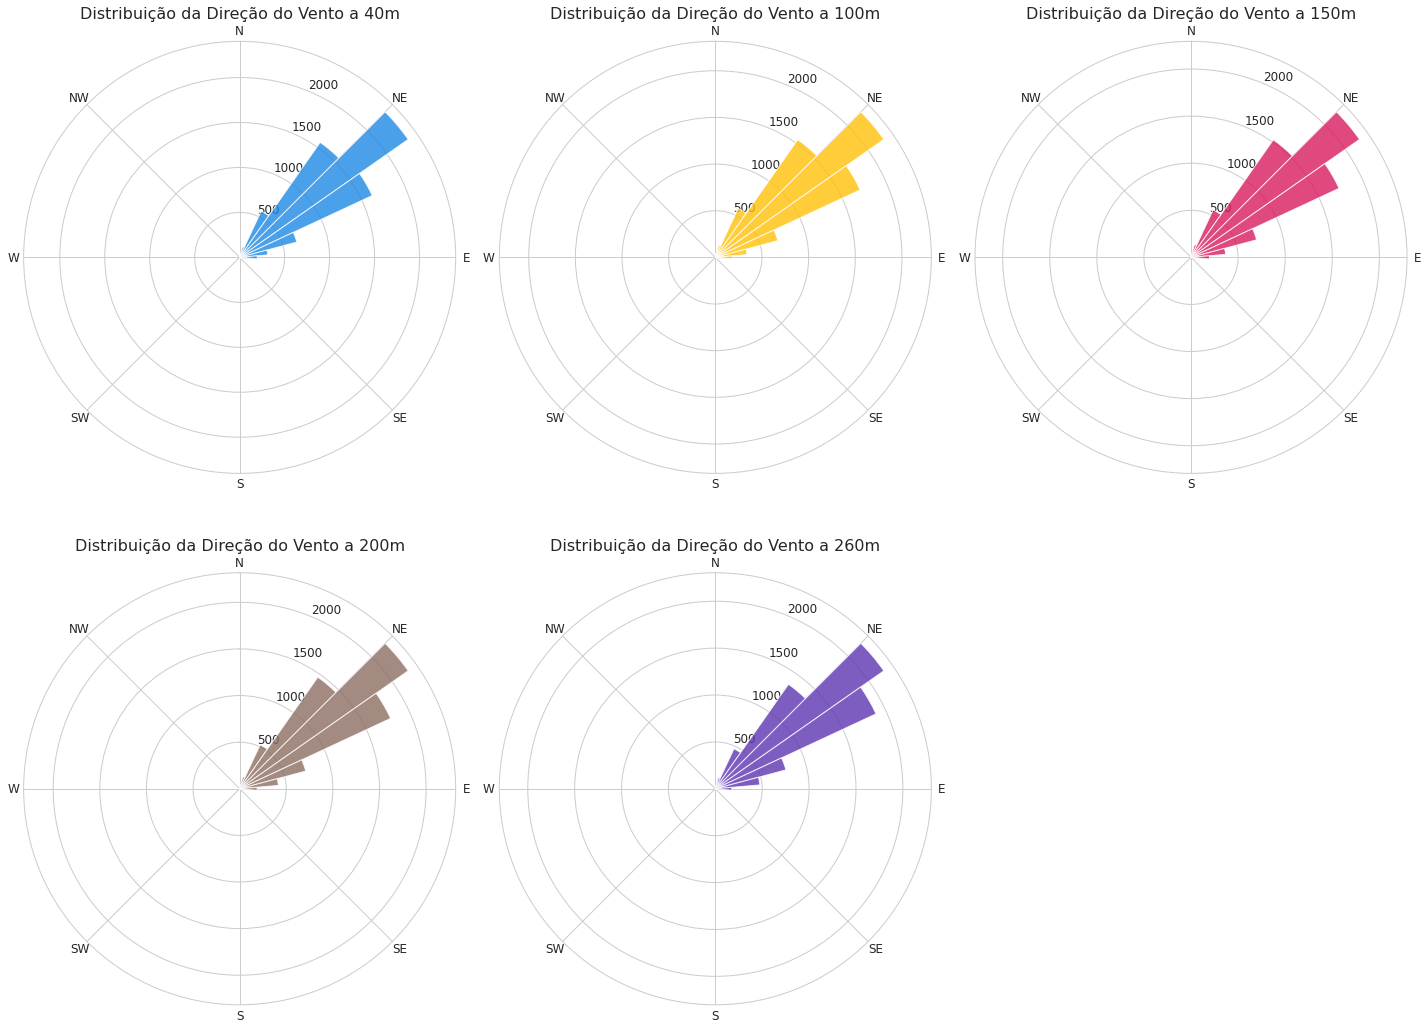

In [32]:
# Selecionar algumas alturas representativas
selected_heights = [40, 100, 150, 200, 260]
wdir_selected = [f'wdir{h}' for h in selected_heights if f'wdir{h}' in df.columns]
ws_selected = [f'ws{h}' for h in selected_heights if f'ws{h}' in df.columns]

# Plotar histogramas polares da direção do vento
fig = plt.figure(figsize=(20, 15))
n_cols = 3
n_rows = int(np.ceil(len(wdir_selected) / n_cols))

for i, (wdir_col, ws_col) in enumerate(zip(wdir_selected, ws_selected)):
    height = wdir_col.replace('wdir', '')
    
    ax = fig.add_subplot(n_rows, n_cols, i+1, projection='polar')
    
    # Converter direção para radianos
    directions = np.radians(df[wdir_col].dropna())
    
    # Histograma polar
    hist, bins = np.histogram(directions, bins=36, range=(0, 2*np.pi))
    width = (bins[1] - bins[0])
    ax.bar(bins[:-1], hist, width=width, alpha=0.8, color=colors[i % len(colors)], edgecolor='white')
    
    # Configurar rótulos
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)  # sentido horário
    ax.set_title(f'Distribuição da Direção do Vento a {height}m', fontsize=16)
    
    # Adicionar rótulos de direção
    ax.set_xticks(np.radians([0, 45, 90, 135, 180, 225, 270, 315]))
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'], fontsize=12)
    
plt.tight_layout()
plt.show()

## 4. Análise de Variabilidade da Direção do Vento

Vamos analisar como a direção do vento varia ao longo do tempo e entre diferentes alturas.

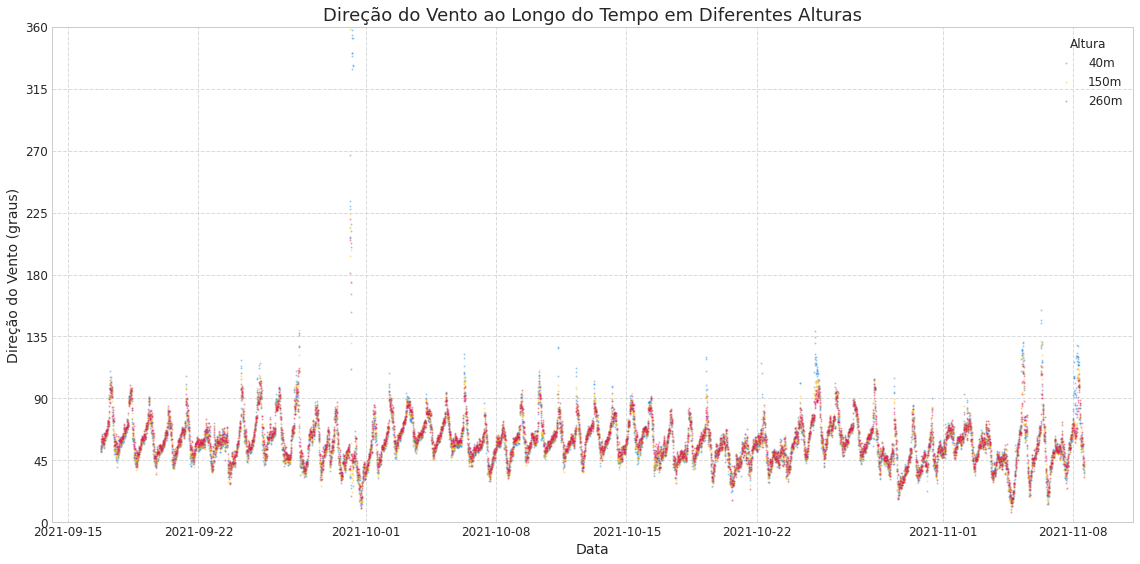

In [35]:
# Selecionar direções em alturas específicas para análise
heights_for_analysis = [40, 150, 260]
wdir_analysis = [f'wdir{h}' for h in heights_for_analysis if f'wdir{h}' in df.columns]

# Plotar séries temporais da direção do vento
plt.figure(figsize=(16, 8))
for i, col in enumerate(wdir_analysis):
    plt.scatter(df.index, df[col], marker='.', alpha=0.3, s=5, 
                label=f'{col.replace("wdir", "")}m', color=colors[i % len(colors)])

plt.title('Direção do Vento ao Longo do Tempo em Diferentes Alturas', fontsize=18)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Direção do Vento (graus)', fontsize=14)
plt.ylim(0, 360)
plt.yticks(np.arange(0, 361, 45))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Altura', fontsize=12)
plt.tight_layout()
plt.show()

In [36]:
# Analisar a distribuição horária da direção do vento
def calculate_hourly_direction(df, wdir_col):
    """Calcula a direção média do vento por hora usando estatística circular."""
    hourly_direction = []
    for hour in range(24):
        hour_data = df[df.index.hour == hour][wdir_col].dropna()
        if len(hour_data) > 0:
            stats = circular_stats(hour_data)
            hourly_direction.append({
                'hour': hour,
                'mean_direction': stats['mean_direction'],
                'resultant_length': stats['resultant_length'],
                'std': stats['circular_std']
            })
    return pd.DataFrame(hourly_direction)

# Calcular direção horária para algumas alturas
height_hourly_stats = {}
for col in wdir_analysis:
    height = col.replace('wdir', '')
    hourly_stats = calculate_hourly_direction(df, col)
    height_hourly_stats[height] = hourly_stats

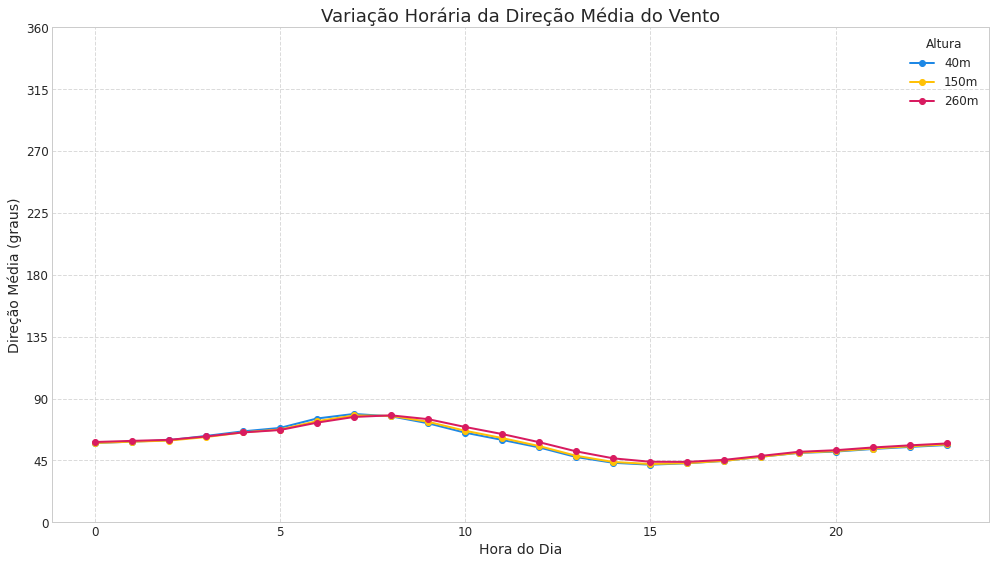

In [38]:
# Plotar variação horária da direção do vento
plt.figure(figsize=(14, 8))

for i, (height, stats) in enumerate(height_hourly_stats.items()):
    plt.plot(stats['hour'], stats['mean_direction'], marker='o', linestyle='-', 
             linewidth=2, label=f'{height}m', color=colors[i % len(colors)])

plt.title('Variação Horária da Direção Média do Vento', fontsize=18)
plt.xlabel('Hora do Dia', fontsize=14)
plt.ylabel('Direção Média (graus)', fontsize=14)
plt.ylim(0, 360)
plt.yticks(np.arange(0, 361, 45))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Altura', fontsize=12)
plt.tight_layout()
plt.show()

## 5. Análise da Rotação do Vento com a Altura

É comum que a direção do vento varie com a altura devido à força de Coriolis e atrito superficial. Este fenômeno é conhecido como espiral de Ekman.

In [39]:
# Calcular diferença média de direção entre alturas consecutivas
wind_turning = []

for i in range(len(wdir_cols) - 1):
    lower_col = wdir_cols[i]
    upper_col = wdir_cols[i+1]
    lower_height = int(lower_col.replace('wdir', ''))
    upper_height = int(upper_col.replace('wdir', ''))
    
    # Calcular diferença de direção (considerando natureza circular)
    diff = (df[upper_col] - df[lower_col]) % 360
    diff = np.where(diff > 180, diff - 360, diff)
    
    wind_turning.append({
        'lower_height': lower_height,
        'upper_height': upper_height,
        'height_diff': upper_height - lower_height,
        'mean_diff': np.nanmean(diff),
        'median_diff': np.nanmedian(diff),
        'std_diff': np.nanstd(diff)
    })

turning_df = pd.DataFrame(wind_turning)
turning_df

,lower_height,upper_height,height_diff,mean_diff,median_diff,std_diff
0,40,50,10,-0.005625,0.04,0.922982
1,50,60,10,-0.031558,0.01,0.824671
2,60,70,10,-0.019410,0.02,0.718390
3,70,80,10,-0.000464,0.03,0.678586
4,80,90,10,0.004899,0.03,0.543427
5,90,100,10,0.009503,0.02,0.408410
6,100,110,10,0.011594,0.03,0.405778
7,110,120,10,0.016294,0.03,0.344804
8,120,130,10,0.025815,0.03,0.347429
9,130,140,10,0.032669,0.04,0.339008


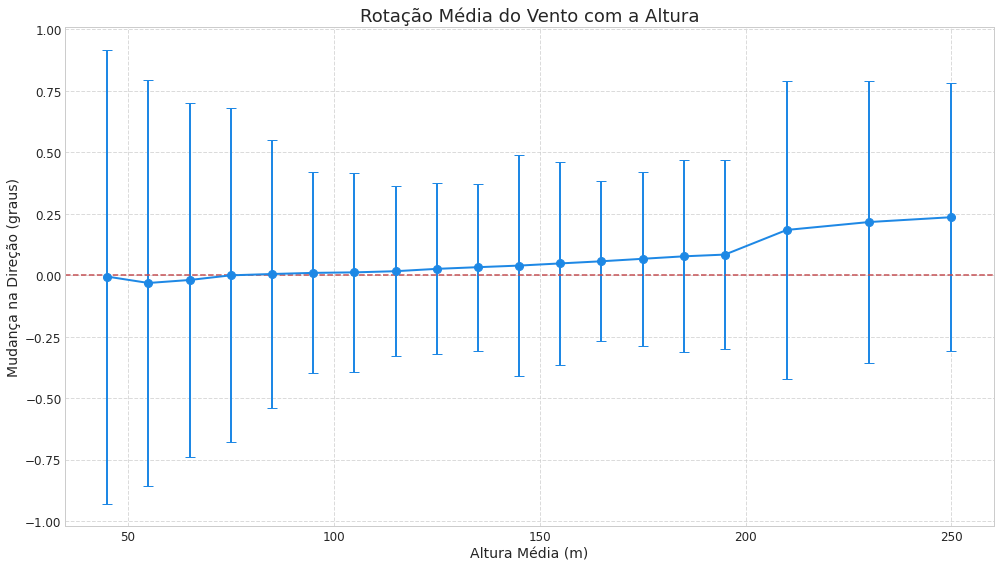

In [ ]:
# Visualizar a rotação do vento com a altura
plt.figure(figsize=(14, 8))

mid_heights = (turning_df['lower_height'] + turning_df['upper_height']) / 2
plt.errorbar(mid_heights, turning_df['mean_diff'], yerr=turning_df['std_diff'], 
             fmt='o-', capsize=5, linewidth=2, markersize=8, color=colors[0])

plt.axhline(y=0, color='r', linestyle='--', linewidth=1.5)

plt.title('Rotação Média do Vento com a Altura', fontsize=18)
plt.xlabel('Altura Média (m)', fontsize=14)
plt.ylabel('Mudança na Direção (graus)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

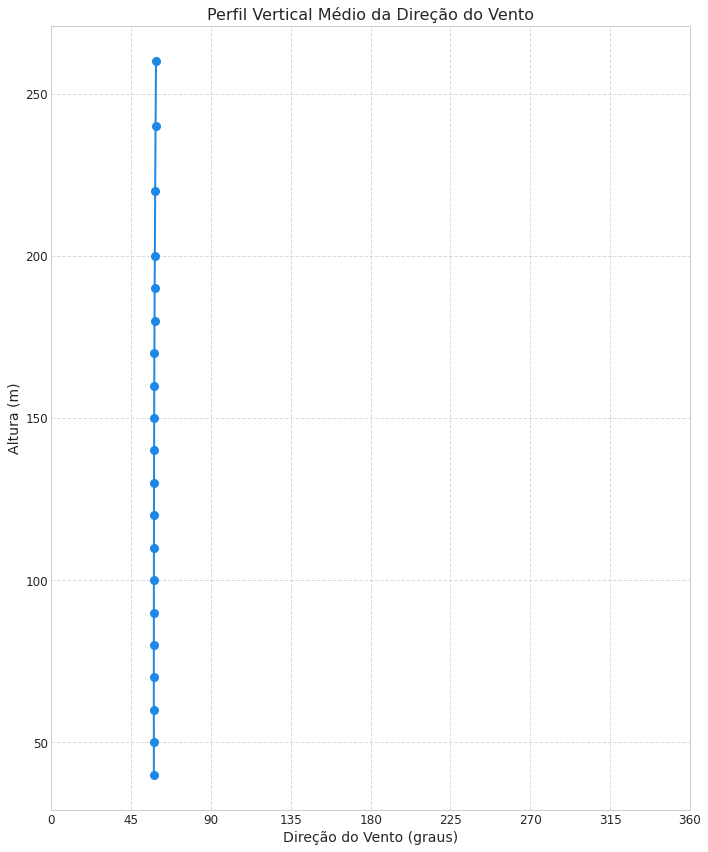

In [40]:
# Plotar perfil médio da direção do vento
mean_wdir = circular_df['mean_direction'].values
heights = circular_df['height'].values

plt.figure(figsize=(10, 12))
plt.plot(mean_wdir, heights, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('Perfil Vertical Médio da Direção do Vento', fontsize=16)
plt.xlabel('Direção do Vento (graus)', fontsize=14)
plt.ylabel('Altura (m)', fontsize=14)
plt.xlim(0, 360)
plt.xticks(np.arange(0, 361, 45))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 6. Relação entre Direção e Velocidade do Vento

Vamos analisar a relação entre a direção e a velocidade do vento para entender possíveis padrões.

In [41]:
# Selecionar algumas alturas para análise
heights_for_joint = [40, 150, 260]
joint_data = []

for h in heights_for_joint:
    if f'wdir{h}' in df.columns and f'ws{h}' in df.columns:
        joint_data.append((h, f'wdir{h}', f'ws{h}'))

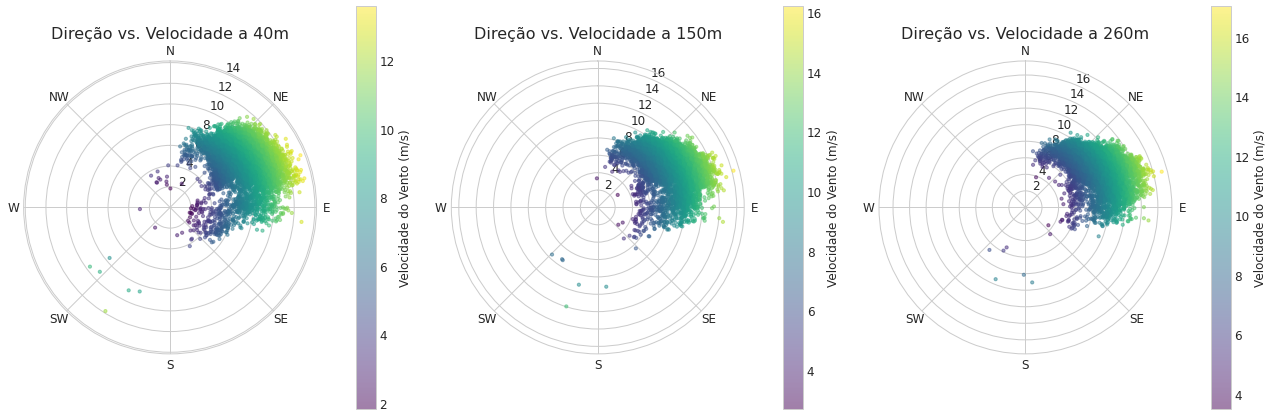

In [42]:
# Criar gráficos de dispersão polares para mostrar relação entre direção e velocidade
fig = plt.figure(figsize=(18, 6))

for i, (height, wdir_col, ws_col) in enumerate(joint_data):
    ax = fig.add_subplot(1, len(joint_data), i+1, projection='polar')
    
    # Remover valores NaN
    mask = ~(df[wdir_col].isna() | df[ws_col].isna())
    directions = np.radians(df.loc[mask, wdir_col])
    speeds = df.loc[mask, ws_col]
    
    # Plotar pontos com cor baseada na velocidade
    sc = ax.scatter(directions, speeds, c=speeds, cmap='viridis', 
                   alpha=0.5, s=10, edgecolor=None)
    
    # Configurar eixos
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)  # sentido horário
    ax.set_title(f'Direção vs. Velocidade a {height}m', fontsize=16)
    
    # Adicionar rótulos de direção
    ax.set_xticks(np.radians([0, 45, 90, 135, 180, 225, 270, 315]))
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'], fontsize=12)
    
    # Adicionar barra de cores
    cbar = plt.colorbar(sc, ax=ax, pad=0.1)
    cbar.set_label('Velocidade do Vento (m/s)', fontsize=12)

plt.tight_layout()
plt.show()